# Network Visualisation of Singapore's Public Bus Transport System

First, to obtain the data set, we need to make API calls using the one provided for LTA's DataMall. 

In [ ]:
import requests

In [ ]:
api_key = 'your_API_key'
base_url = 'the_URL_to_make_API_calls_on'

In [ ]:
headers = {
    'AccountKey' : api_key,
    'accept' : 'application/json'
}

In [ ]:
page = 1
all_values = []

while True:
    params = {
        '$skip': (page - 1)*500
    }
    response = requests.get(base_url, 
                            params = params,
                            headers = headers)
    print(f"extracting page {page}")
    values = response.json()['value']
    all_values.extend(values)
    if len(values) != 500:
        break
    page += 1

In [1]:
import pandas as pd 

In [ ]:
file_name = pd.DataFrame(all_values)

In [ ]:
# To convert to a csv file if required
file_name.to_csv("file_name.csv", index = False)

Next, to sort the obtained data set: 
First, import the origin destination trip records,

In [2]:
od_three_months = pd.read_csv('Data/od_three_months.csv',\
                usecols=['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE', 'TOTAL_TRIPS'])

od_three_months['ORIGIN_PT_CODE'] = od_three_months['ORIGIN_PT_CODE'].astype("str").str.zfill(5)
od_three_months['DESTINATION_PT_CODE'] = od_three_months['DESTINATION_PT_CODE'].astype("str").str.zfill(5)

Since we have three months worth of data, it is easier to analyse it when the data is combined as a whole. 
The `.groupby` method takes in an attribute, and groups the data according to the categories, then applies a function to the category. 

In [3]:
od_modified = od_three_months.groupby(['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE'])['TOTAL_TRIPS'].sum()

In [4]:
od_stops = od_modified.reset_index()

In [5]:
od_stops.head()

ORIGIN_PT_CODE DESTINATION_PT_CODE  TOTAL_TRIPS
0          01012               01112         4821
1          01012               01113         3660
2          01012               01121         2306
3          01012               01211         3432
4          01012               01311         5780

Next, import the bus stop data. 

In [6]:
bus_stops = pd.read_csv('Data/bus_stops.csv')
bus_stops["BusStopCode"] = bus_stops["BusStopCode"].astype("str").str.zfill(5)
bus_stops.head(5)

BusStopCode       RoadName          Description  Latitude   Longitude
0       01012    Victoria St  Hotel Grand Pacific  1.296848  103.852536
1       01013    Victoria St      St. Joseph's Ch  1.297710  103.853225
2       01019    Victoria St      Bras Basah Cplx  1.296990  103.853022
3       01029  Nth Bridge Rd         Opp Natl Lib  1.296673  103.854414
4       01039  Nth Bridge Rd           Bugis Cube  1.298208  103.855491

For a more comprehensive overview of where the bus stops are located, we will require the subzone name and region of each bus stop. 

In [7]:
import geopandas as gpd
import numpy as np 
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [8]:
geo_df = gpd.read_file('Data/MP19_SZ_No_Sea/URA_MP19_SUBZONE_NO_SEA_PL.shp')

In [9]:
geo_df_reproj = geo_df.to_crs(3857)

In [10]:
geo_df_reproj.columns

Index(['SUBZONE_NO', 'SUBZONE_N', 'SUBZONE_C', 'CA_IND', 'PLN_AREA_N',
       'PLN_AREA_C', 'REGION_N', 'REGION_C', 'INC_CRC', 'FMEL_UPD_D',
       'geometry'],
      dtype='object')

In [11]:
from shapely.geometry import Point
# Creating a point geometry column
bus_stops['geometry'] = bus_stops.apply(lambda x: Point((x.Longitude, x.Latitude)),
                                       axis = 1)

In [12]:
# Create a GeoDataFrame from the original bus_stops DataFrame
bus_stops_geo = gpd.GeoDataFrame(bus_stops, 
                                 crs = "epsg:4326",
                                 geometry = bus_stops.geometry)
bus_stops_geo_reproj = bus_stops_geo.to_crs(3857)

In [13]:
joined_gdf = gpd.sjoin(bus_stops_geo_reproj, 
                       geo_df_reproj, 
                       how = 'left')

As I will only require the BusStopCode, Subzone Name and Region Name, the geo_df obtained needs to be subset by columns. 
I will also need to convert the subsequent GeoDataFrame into a DataFrame. 

In [14]:
joined_gdf.columns

Index(['BusStopCode', 'RoadName', 'Description', 'Latitude', 'Longitude',
       'geometry', 'index_right', 'SUBZONE_NO', 'SUBZONE_N', 'SUBZONE_C',
       'CA_IND', 'PLN_AREA_N', 'PLN_AREA_C', 'REGION_N', 'REGION_C', 'INC_CRC',
       'FMEL_UPD_D'],
      dtype='object')

In [15]:
# Subset the current joined geo_df to get the columns I need.
required_bus_stops = joined_gdf[['BusStopCode', 'SUBZONE_N', 'PLN_AREA_N', 'REGION_N']]
required_bus_stops.head()

BusStopCode SUBZONE_N     PLN_AREA_N        REGION_N
0       01012  VICTORIA         ROCHOR  CENTRAL REGION
1       01013  VICTORIA         ROCHOR  CENTRAL REGION
2       01019     BUGIS  DOWNTOWN CORE  CENTRAL REGION
3       01029     BUGIS  DOWNTOWN CORE  CENTRAL REGION
4       01039     BUGIS  DOWNTOWN CORE  CENTRAL REGION

In [16]:
bus_stops_df = pd.DataFrame(required_bus_stops)

In [17]:
# To join the 2 datasets we have obtained:
od_stops = pd.merge(od_stops, bus_stops_df,\
                    how = 'left', left_on ='ORIGIN_PT_CODE', right_on = 'BusStopCode')
od_stops = pd.merge(od_stops, bus_stops_df,\
             how = 'left', left_on = 'DESTINATION_PT_CODE', right_on = 'BusStopCode')
od_stops.head(10)

ORIGIN_PT_CODE DESTINATION_PT_CODE  TOTAL_TRIPS BusStopCode_x SUBZONE_N_x  \
0          01012               01112         4821         01012    VICTORIA   
1          01012               01113         3660         01012    VICTORIA   
2          01012               01121         2306         01012    VICTORIA   
3          01012               01211         3432         01012    VICTORIA   
4          01012               01311         5780         01012    VICTORIA   
5          01012               01549           22         01012    VICTORIA   
6          01012               01559           78         01012    VICTORIA   
7          01012               07371          227         01012    VICTORIA   
8          01012               60011          321         01012    VICTORIA   
9          01012               60021          343         01012    VICTORIA   

  PLN_AREA_N_x      REGION_N_x BusStopCode_y    SUBZONE_N_y   PLN_AREA_N_y  \
0       ROCHOR  CENTRAL REGION         01112       VICTORIA         ROCHOR   
1       ROCHOR  CENTRAL REGION         01113          BUGIS  DOWNTOWN CORE   
2       ROCHOR  CENTRAL REGION         01121   ROCHOR CANAL         ROCHOR   
3       ROCHOR  CENTRAL REGION         01211       CRAWFORD        KALLANG   
4       ROCHOR  CENTRAL REGION         01311       LAVENDER        KALLANG   
5       ROCHOR  CENTRAL REGION         01549   KAMPONG GLAM         ROCHOR   
6       ROCHOR  CENTRAL REGION         01559   KAMPONG GLAM         ROCHOR   
7       ROCHOR  CENTRAL REGION         07371       LAVENDER        KALLANG   
8       ROCHOR  CENTRAL REGION         60011  KALLANG BAHRU        KALLANG   
9       ROCHOR  CENTRAL REGION         60021  KALLANG BAHRU        KALLANG   

       REGION_N_y  
0  CENTRAL REGION  
1  CENTRAL REGION  
2  CENTRAL REGION  
3  CENTRAL REGION  
4  CENTRAL REGION  
5  CENTRAL REGION  
6  CENTRAL REGION  
7  CENTRAL REGION  
8  CENTRAL REGION  
9  CENTRAL REGION

In [18]:
# rename the df for easier use
final_df = od_stops

In [19]:
final_df.shape

(372020, 11)

A couple of test cases to visualise how to obtain the general graph object function. 

In [20]:
import seaborn as sns

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
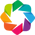

In [21]:
from holoviews import opts, dim
import holoviews as hv

hv.extension('bokeh')
hv.output(size=200)

## Filtering the dataframe
The function `filter_trips()` below allows us to easily filter the data frame we are working on, to obtain a subset of the data set.  

In [22]:
def filter_trips(od_stops,
                 level, # 'SUBZONE', 'PLN_AREA', 'REGION'
                 selected_origin, # ['VICTORIA']
                 selected_dest, # 'all' OR ['CHONG BOON', 'CHONG PANG']
                 min_trips): # 5000
    '''
    Filters the origin-destination dataframe for selected origin-destination pairs
    and for a minimum number of trips.

    Args:
        od_stops: Pandas dataframe of all origin-destination bus stops and trip numbers
        level: Which geospatial level to filter at (subzone, planning area, or region)
        selected_origin: The origin area(s) in the level selected 
        selected_dest: The destination area(s) in the level selected
        min_trips: integer value of the minimum number of trips to be filtered
    Returns:
        What do you return? Pandas dataframe which is filtered
    Raises:
        AssertionError: For incorrect inputs
    '''

    # Check that the level that was passed in is correct
    if level not in ['SUBZONE', 'PLN_AREA', 'REGION']:
        raise AssertionError("Error! Please key in a correct level.")

    # Check that there is some selection
    if len(selected_origin) == 0:
        raise AssertionError("Error! Please select at least one origin.")
    if len(selected_dest) == 0:
        raise AssertionError("Error! Please select at least one destination.")

    # Check that min_trips is at least 1
    if min_trips < 0:
        raise AssertionError("Error! Please key in a positive integer value \
                                to be the minimum number of trips.")
        
    def generate_boolean_mask(df, level, origin_dest, selected):
        if selected == 'all':
            boolean_mask = ~df[f'{level}_N_{origin_dest}'].isin([])
        else:
            boolean_mask = df[f'{level}_N_{origin_dest}'].isin(selected)
        return boolean_mask

    boolean_mask_origin = generate_boolean_mask(od_stops,
                                           level,
                                           "x",
                                           selected_origin)

    boolean_mask_dest = generate_boolean_mask(od_stops,
                                           level,
                                           "y",
                                           selected_dest)

    boolean_mask_mintrips = od_stops['TOTAL_TRIPS'] >= min_trips

    output = od_stops[boolean_mask_origin & boolean_mask_dest & boolean_mask_mintrips].reset_index(drop = True)

    return output

In [23]:
filter_trips(final_df, 'SUBZONE', ['VICTORIA'], ['BUGIS'], 5)

ORIGIN_PT_CODE DESTINATION_PT_CODE  TOTAL_TRIPS BusStopCode_x SUBZONE_N_x  \
0          01012               01113         3660         01012    VICTORIA   
1          01013               01113          617         01013    VICTORIA   
2          07518               01511          440         07518    VICTORIA   
3          07518               01621          411         07518    VICTORIA   
4          07518               01639         1699         07518    VICTORIA   
5          07569               01511          227         07569    VICTORIA   
6          07569               01621          130         07569    VICTORIA   
7          07569               01639          415         07569    VICTORIA   

  PLN_AREA_N_x      REGION_N_x BusStopCode_y SUBZONE_N_y   PLN_AREA_N_y  \
0       ROCHOR  CENTRAL REGION         01113       BUGIS  DOWNTOWN CORE   
1       ROCHOR  CENTRAL REGION         01113       BUGIS  DOWNTOWN CORE   
2       ROCHOR  CENTRAL REGION         01511       BUGIS  DOWNTOWN CORE   
3       ROCHOR  CENTRAL REGION         01621       BUGIS  DOWNTOWN CORE   
4       ROCHOR  CENTRAL REGION         01639       BUGIS  DOWNTOWN CORE   
5       ROCHOR  CENTRAL REGION         01511       BUGIS  DOWNTOWN CORE   
6       ROCHOR  CENTRAL REGION         01621       BUGIS  DOWNTOWN CORE   
7       ROCHOR  CENTRAL REGION         01639       BUGIS  DOWNTOWN CORE   

       REGION_N_y  
0  CENTRAL REGION  
1  CENTRAL REGION  
2  CENTRAL REGION  
3  CENTRAL REGION  
4  CENTRAL REGION  
5  CENTRAL REGION  
6  CENTRAL REGION  
7  CENTRAL REGION

# Generating the chord diagram

In [24]:
# Shaun's function for generating the chord diagram data

pd.options.mode.chained_assignment = None

selected_towns = ['BUKIT BATOK', 'CLEMENTI', 'JURONG EAST']
def generate_chord_diagram(final_df, areas):
    
    # Filter the data for only the areas we have selected
    selected_areas_df = final_df[final_df['PLN_AREA_N_x'].isin(areas) & final_df['PLN_AREA_N_y'].isin(areas)]
    
    # Filter the data for the rest of the trips
    other_areas_df = final_df[(final_df['PLN_AREA_N_x'].isin(areas) & ~final_df['PLN_AREA_N_y'].isin(areas)) | (~final_df['PLN_AREA_N_x'].isin(areas) & final_df['PLN_AREA_N_y'].isin(areas))]
    
    # Convert the other non-selected towns into "OTHERS"
    other_areas_df['PLN_AREA_N_x'] = [pln_area if pln_area in areas else 'ZZOTHERS' for pln_area in other_areas_df['PLN_AREA_N_x']]
    other_areas_df['PLN_AREA_N_y'] = [pln_area if pln_area in areas else 'ZZOTHERS' for pln_area in other_areas_df['PLN_AREA_N_y']]
    
    # Add them all back together
    limited_areas_df = pd.concat([selected_areas_df, other_areas_df], ignore_index = True)
    
    # Group by the planning area and sum the total trips
    trips2 = limited_areas_df.groupby(['PLN_AREA_N_x', 'PLN_AREA_N_y'])['TOTAL_TRIPS'].sum()
    links2 = pd.DataFrame.from_records(list(trips2.index), columns = ['start', 'end'])
    links2['trips'] = trips2.values
    
    links2['set'] = ''
    for i in range(len(links2)):
        links2['set'][i] = ','.join(sorted([links2['start'][i], links2['end'][i]]))
    chord_df = links2.groupby('set')['trips'].sum().reset_index()
    chord_final = pd.concat([chord_df, chord_df['set'].str.split(',', expand = True)], axis = 1)
    chord_final.drop('set', inplace = True, axis = 1)
    chord_final.columns = ['value', 'source', 'target']
    chord_final['source'] = chord_final['source'].replace({k:str(i) for i,k in enumerate(selected_towns)}).replace({'ZZOTHERS': len(selected_towns)}).astype('int32')
    chord_final['target'] = chord_final['target'].replace({k:str(i) for i,k in enumerate(selected_towns)}).replace({'ZZOTHERS': len(selected_towns)}).astype('int32')
    
    nodes = hv.Dataset(pd.DataFrame(selected_towns + ['OTHERS'], columns = ['name']), 'index')
    
    return nodes, chord_final.loc[:,['source', 'target', 'value']]

Note that this function ensures that:
* Trips are summed bidirectionally (ie it doesn't matter if it's A -> B or B -> A, we sum the traffic both ways.
* `OTHERS` will always be the last category, regardless of how many towns you pass in. The links will also never be coloured with the `OTHERS` colour.

In [25]:
selected_towns = ['BUKIT BATOK', 'CLEMENTI', 'JURONG EAST']
nodes, links = generate_chord_diagram(final_df, selected_towns)

In [26]:
from bokeh.models import HoverTool, ColumnDataSource
source = ColumnDataSource(generate_chord_diagram(final_df, selected_towns)) # this input is probably wrong
tooltips = [ ('Source', '@start'), ('Target', '@end'), ('Value', '@trips')]
hover = HoverTool(tooltips = tooltips)

TypeError: not all arguments converted during string formatting

In [107]:
chord = hv.Chord((links, nodes)).select(value=(5, None))
chord.opts(tools=[hover], node_color=dim('index').str(),
           edge_color=dim('source').str(),
           labels='name', 
           cmap='Category10',
           edge_cmap='Category10')

NameError: name 'hover' is not defined

In [109]:
selected_towns = ['CLEMENTI', 'BUKIT BATOK', 'JURONG EAST']
nodes, links = generate_chord_diagram(final_df, selected_towns)
chord = hv.Chord((links, nodes))
chord.opts(node_color=dim('index').str(),
           edge_color=dim('source').str(),
           labels='name', 
           cmap='Category10',
           edge_cmap='Category10')

:Chord   [source,target]   (value)

In [108]:
selected_towns = ['BISHAN', 'TOA PAYOH', 'NOVENA']
nodes, links = generate_chord_diagram(final_df, selected_towns)
chord = hv.Chord((links, nodes))
chord.opts(node_color=dim('index').str(),
           edge_color=dim('source').str(),
           labels='name', 
           cmap='Category10',
           edge_cmap='Category10')

:Chord   [source,target]   (value)

In [ ]:
selected_towns = ['TAMPINES', 'BEDOK', 'PASIR RIS']
nodes, links = generate_chord_diagram(final_df, selected_towns)
chord = hv.Chord((links, nodes))
chord.opts(
    opts.Chord(node_color=dim('index').str(),
           edge_color=dim('source').str(),
           labels='name', 
           cmap='Category10',
           edge_cmap='Category10'))

In [ ]:
selected_towns = ['WOODLANDS', 'MANDAI', 'SEMBAWANG', 'YISHUN']
nodes, links = generate_chord_diagram(final_df, selected_towns)
chord = hv.Chord((links, nodes))
chord.opts(node_color=dim('index').str(),
           edge_color=dim('source').str(),
           labels='name', 
           cmap='Category10',
           edge_cmap='Category10')

## Formatting the Data:
After obtaining the filtered dataframe, we need to transform the filtered dataframe into one that can be used for visualisation. 

We will only require BusStopCode_x, BusStopCode_y, as well as the origin and destination level that was previously selected. 

In [ ]:
def format_df(filtered_df, level):

    cols = ['BusStopCode_x', 'BusStopCode_y', f"{level}_N_x", f"{level}_N_y", 'TOTAL_TRIPS']
    
    required = filtered_df[cols]
    
    output = required.rename(columns = {"BusStopCode_x" : "START", "BusStopCode_y" : "END", "TOTAL_TRIPS" : "WEIGHT"})
    # output['WEIGHT_INV'] = 1/output.WEIGHT
    
    return output

In [ ]:
desired_df = format_df(filter_trips(final_df, 'PLN_AREA', ['CLEMENTI'], ['JURONG EAST'], 5), 'PLN_AREA')
desired_df

## Visualisation of Data 
1) Network Graph

In [ ]:
import community
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
G = nx.from_pandas_edgelist(desired_df, 
                           source = "START",
                           target = "END",
                           edge_attr = "WEIGHT")

In [ ]:
# Labelling of nodes
for node in G.nodes():
    G.nodes()[node]["label"] = str(node)

In [ ]:
G.nodes(data = True)

# Store subzone/planning area/region in nodes, 
# number of trips in edges

In [ ]:
G.edges()

In [ ]:
# pos = nx.spring_layout(G)

nx.draw(G, with_labels = True)

2) Chord Diagram

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from holoviews import opts, dim
import holoviews as hv

hv.extension('bokeh')
hv.output(size=200)

In [ ]:
links = desired_df
links['trips'] = desired_df.WEIGHT

links.head()

In [ ]:
names = links.START + '/' + links.END
plt.figure(figsize=(12,10))
sns.barplot( x=links.trips[:], y=names[:], orient="h") ;

In [ ]:
chord=hv.Chord(links[:])
chord.opts(node_color= 'index', edge_color='START',\
          label_index='index', cmap='Category10', edge_cmap='Category10')

In [ ]:
links = pd.DataFrame.from_records(list(trips.index),\
                                 columns = ['start', 'end'])
links['trips'] = trips.values

links.head()

In [ ]:
names = links.start + '/' + links.end
plt.figure(figsize=(12,10))
sns.barplot( x=links.trips[:], y=names[:], orient="h") ;

In [ ]:
chord=hv.Chord(links[:60])
chord.opts(node_color='index', edge_color='start',\
          label_index='index', cmap='Category10', edge_cmap='Category10')

# Analysing the data
## Evaluation Points
1) Area with the greatest volume of passenger flow (?) -- assumed to be the town area/jurong industrial area
2) Bus stop density (within subzones? if it's too narrow then perhaps within a planning area?)
3) Which bus services are under/overused?
4) Which subzones have the fewest number of bus stops, and how will people access those subzones, if not by bus?
5) Are there many bus routes that overlap, and if so, is the passenger volume evenly distributed over them?
6) To consider the relationship of the ridership + number of bus stops in the area: 
        a. population density 
        b. the type of residence in the planning area 
        c. land size 
        d. number of bus stops per km^2
7) Line graph to show the relationship between the number of bus stops and the number of trips (from node to node) 
8) Relationship between the ridership and bus stop density/number of bus stops per km^2/population density/planning area level/subzone level. (Plot as points, then draw a best fit line). 

## Possible fun facts to search up
1) Number of bus stops within the area selected
2) Differences between the various subzones/planning areas after evaluation from above

In [27]:
#1 Area with the greatest volume of passenger flow OUT OF the area
# Assessed by total trips TO destination bus stop, using final_df
greatest_trips_out_of_area = final_df.groupby('ORIGIN_PT_CODE')['TOTAL_TRIPS'].sum()
greatest_trips_out_of_area.sort_values(ascending=False)

ORIGIN_PT_CODE
22009    4378682
46009    3412648
75009    2993823
52009    2265524
59009    2264948
          ...   
32061          5
32071          4
46239          3
59599          1
22579          1
Name: TOTAL_TRIPS, Length: 5013, dtype: int64

In [28]:
bus_stops_df[bus_stops_df['BusStopCode'] == '22009']

BusStopCode            SUBZONE_N   PLN_AREA_N     REGION_N
977       22009  JURONG WEST CENTRAL  JURONG WEST  WEST REGION

In [29]:
#1b Area with the greatest volume of passenger flow INTO the area
# Assessed by total trips TO destination bus stop, using final_df
greatest_trips_into_area = final_df.groupby('DESTINATION_PT_CODE')['TOTAL_TRIPS'].sum()
greatest_trips_into_area.sort_values(ascending=False)

DESTINATION_PT_CODE
22009    3781990
75009    2982705
46009    2607965
84009    2220621
52009    2099131
          ...   
46219          5
47711          4
46109          4
32059          4
22571          4
Name: TOTAL_TRIPS, Length: 5017, dtype: int64

In [30]:
bus_stops_df[bus_stops_df['BusStopCode'] == '22009']

BusStopCode            SUBZONE_N   PLN_AREA_N     REGION_N
977       22009  JURONG WEST CENTRAL  JURONG WEST  WEST REGION

In [31]:
final_df

ORIGIN_PT_CODE DESTINATION_PT_CODE  TOTAL_TRIPS BusStopCode_x  \
0               01012               01112         4821         01012   
1               01012               01113         3660         01012   
2               01012               01121         2306         01012   
3               01012               01211         3432         01012   
4               01012               01311         5780         01012   
...               ...                 ...          ...           ...   
372015          99189               98239           26         99189   
372016          99189               99019            3         99189   
372017          99189               99029           24         99189   
372018          99189               99039           53         99189   
372019          99189               99049          107         99189   

           SUBZONE_N_x PLN_AREA_N_x      REGION_N_x BusStopCode_y  \
0             VICTORIA       ROCHOR  CENTRAL REGION         01112   
1             VICTORIA       ROCHOR  CENTRAL REGION         01113   
2             VICTORIA       ROCHOR  CENTRAL REGION         01121   
3             VICTORIA       ROCHOR  CENTRAL REGION         01211   
4             VICTORIA       ROCHOR  CENTRAL REGION         01311   
...                ...          ...             ...           ...   
372015  CHANGI AIRPORT       CHANGI     EAST REGION         98239   
372016  CHANGI AIRPORT       CHANGI     EAST REGION         99019   
372017  CHANGI AIRPORT       CHANGI     EAST REGION         99029   
372018  CHANGI AIRPORT       CHANGI     EAST REGION         99039   
372019  CHANGI AIRPORT       CHANGI     EAST REGION         99049   

         SUBZONE_N_y   PLN_AREA_N_y      REGION_N_y  
0           VICTORIA         ROCHOR  CENTRAL REGION  
1              BUGIS  DOWNTOWN CORE  CENTRAL REGION  
2       ROCHOR CANAL         ROCHOR  CENTRAL REGION  
3           CRAWFORD        KALLANG  CENTRAL REGION  
4           LAVENDER        KALLANG  CENTRAL REGION  
...              ...            ...             ...  
372015   LOYANG EAST      PASIR RIS     EAST REGION  
372016   CHANGI WEST         CHANGI     EAST REGION  
372017   CHANGI WEST         CHANGI     EAST REGION  
372018   CHANGI WEST         CHANGI     EAST REGION  
372019   CHANGI WEST         CHANGI     EAST REGION  

[372020 rows x 11 columns]

In [32]:
bus_stops_df

BusStopCode       SUBZONE_N     PLN_AREA_N        REGION_N
0          01012        VICTORIA         ROCHOR  CENTRAL REGION
1          01013        VICTORIA         ROCHOR  CENTRAL REGION
2          01019           BUGIS  DOWNTOWN CORE  CENTRAL REGION
3          01029           BUGIS  DOWNTOWN CORE  CENTRAL REGION
4          01039           BUGIS  DOWNTOWN CORE  CENTRAL REGION
...          ...             ...            ...             ...
5044       99139    CHANGI POINT         CHANGI     EAST REGION
5045       99161  CHANGI AIRPORT         CHANGI     EAST REGION
5046       99171  CHANGI AIRPORT         CHANGI     EAST REGION
5047       99181    CHANGI POINT         CHANGI     EAST REGION
5048       99189  CHANGI AIRPORT         CHANGI     EAST REGION

[5049 rows x 4 columns]

In [68]:
#2 Bus Stop Density (within Subzones)
# 1. Count the number of bus stops per subzone. 
req_cols = ['BusStopCode', 'SUBZONE_N']
bs_sz = bus_stops_df[req_cols].groupby('SUBZONE_N').count()
bs_sz_count = bs_sz.rename(columns = {"BusStopCode" : "count"})

# 1a. Subzone with the greatest number of bus stops. 
bs_sz_sorted = bs_sz_count.sort_values(by='count', ascending=False)
## Subzone MURAI has the most number of bus stops within itself -- 87. 
print(bs_sz_sorted.head(1))

#1b. Subzones with the least number of bus stops == #4 Subzones with the fewest number of bus stops
sz_1_bus_stop = bs_sz_count[bs_sz_count["count"] == 1]
print(sz_1_bus_stop.index)

# 2. Divide by the total land area of the subzones.
# Using GeoPandas Polygon Area to derive this land area below.

           count
SUBZONE_N       
MURAI         87
Index(['BAHAR', 'FOREST HILL', 'ISTANA NEGARA', 'LITTLE INDIA', 'MACKENZIE',
       'MAXWELL', 'MONK'S HILL', 'ORANGE GROVE', 'OXLEY', 'PHILLIP'],
      dtype='object', name='SUBZONE_N')


In [71]:
bs_sz_count.reset_index()

SUBZONE_N  count
0          ADMIRALTY     21
1       AIRPORT ROAD      3
2     ALEXANDRA HILL     24
3    ALEXANDRA NORTH      4
4           ALJUNIED     45
..               ...    ...
307     YISHUN SOUTH     26
308      YISHUN WEST     34
309       YUHUA EAST     17
310       YUHUA WEST     12
311           YUNNAN     51

[312 rows x 2 columns]

In [34]:
geo_df

SUBZONE_NO                SUBZONE_N SUBZONE_C CA_IND       PLN_AREA_N  \
0             1              MARINA EAST    MESZ01      Y      MARINA EAST   
1             5         INSTITUTION HILL    RVSZ05      Y     RIVER VALLEY   
2             1           ROBERTSON QUAY    SRSZ01      Y  SINGAPORE RIVER   
3             1  JURONG ISLAND AND BUKOM    WISZ01      N  WESTERN ISLANDS   
4             2             FORT CANNING    MUSZ02      Y           MUSEUM   
..          ...                      ...       ...    ...              ...   
327           1            UPPER THOMSON    BSSZ01      N           BISHAN   
328           5               SHANGRI-LA    AMSZ05      N       ANG MO KIO   
329           4               TOWNSVILLE    AMSZ04      N       ANG MO KIO   
330           2                MARYMOUNT    BSSZ02      N           BISHAN   
331           6      TUAS VIEW EXTENSION    TSSZ06      N             TUAS   

    PLN_AREA_C           REGION_N REGION_C           INC_CRC  FMEL_UPD_D  \
0           ME     CENTRAL REGION       CR  4FB7E5B1B9455DE0  2019-12-23   
1           RV     CENTRAL REGION       CR  C3C22D1EE31757BD  2019-12-23   
2           SR     CENTRAL REGION       CR  87306ABAF4B67E2E  2019-12-23   
3           WI        WEST REGION       WR  C87E378D3456FC35  2019-12-23   
4           MU     CENTRAL REGION       CR  8E8F2616FFA9E019  2019-12-23   
..         ...                ...      ...               ...         ...   
327         BS     CENTRAL REGION       CR  716DA27F6666AB0C  2019-12-23   
328         AM  NORTH-EAST REGION      NER  9FA8567B39D8D9D7  2019-12-23   
329         AM  NORTH-EAST REGION      NER  F5558D84EBC2AAA7  2019-12-23   
330         BS     CENTRAL REGION       CR  154AA8659ADDE6D7  2019-12-23   
331         TS        WEST REGION       WR  9E88DD747862051B  2019-12-23   

                                              geometry  
0    POLYGON ((33222.981 29588.127, 33222.515 29587...  
1    POLYGON ((28481.446 30886.220, 28483.405 30886...  
2    POLYGON ((28087.344 30540.999, 28087.540 30540...  
3    MULTIPOLYGON (((14557.697 30447.212, 14562.889...  
4    POLYGON ((29542.526 31041.199, 29553.718 31034...  
..                                                 ...  
327  POLYGON ((29036.498 38365.086, 29015.440 38293...  
328  POLYGON ((28228.195 39216.137, 28271.551 39216...  
329  POLYGON ((29649.875 38978.996, 29671.324 38978...  
330  POLYGON ((29469.703 36372.102, 29466.131 36348...  
331  MULTIPOLYGON (((4929.537 32139.355, 4502.137 3...  

[332 rows x 11 columns]

In [47]:
print(geo_df.crs)
geo_df.head(2)

epsg:3414


SUBZONE_NO         SUBZONE_N SUBZONE_C CA_IND    PLN_AREA_N PLN_AREA_C  \
0           1       MARINA EAST    MESZ01      Y   MARINA EAST         ME   
1           5  INSTITUTION HILL    RVSZ05      Y  RIVER VALLEY         RV   

         REGION_N REGION_C           INC_CRC  FMEL_UPD_D  \
0  CENTRAL REGION       CR  4FB7E5B1B9455DE0  2019-12-23   
1  CENTRAL REGION       CR  C3C22D1EE31757BD  2019-12-23   

                                            geometry  
0  POLYGON ((33222.981 29588.127, 33222.515 29587...  
1  POLYGON ((28481.446 30886.220, 28483.405 30886...

In [53]:
geo_df_copy = geo_df.copy()
geo_df_copy['area'] = geo_df_copy['geometry'].area / 10**6
geo_df_copy.head(2)

SUBZONE_NO         SUBZONE_N SUBZONE_C CA_IND    PLN_AREA_N PLN_AREA_C  \
0           1       MARINA EAST    MESZ01      Y   MARINA EAST         ME   
1           5  INSTITUTION HILL    RVSZ05      Y  RIVER VALLEY         RV   

         REGION_N REGION_C           INC_CRC  FMEL_UPD_D  \
0  CENTRAL REGION       CR  4FB7E5B1B9455DE0  2019-12-23   
1  CENTRAL REGION       CR  C3C22D1EE31757BD  2019-12-23   

                                            geometry      area  
0  POLYGON ((33222.981 29588.127, 33222.515 29587...  1.844042  
1  POLYGON ((28481.446 30886.220, 28483.405 30886...  0.392563

In [54]:
geo_df_copy[geo_df_copy["PLN_AREA_N"] == 'BUKIT BATOK']

SUBZONE_NO            SUBZONE_N SUBZONE_C CA_IND   PLN_AREA_N PLN_AREA_C  \
156           3           BRICKWORKS    BKSZ03      N  BUKIT BATOK         BK   
160           2       HONG KAH NORTH    BKSZ02      N  BUKIT BATOK         BK   
175           4               GUILIN    BKSZ04      N  BUKIT BATOK         BK   
181           5             HILLVIEW    BKSZ05      N  BUKIT BATOK         BK   
197           9    BUKIT BATOK SOUTH    BKSZ09      N  BUKIT BATOK         BK   
205           8     BUKIT BATOK EAST    BKSZ08      N  BUKIT BATOK         BK   
206           6     BUKIT BATOK WEST    BKSZ06      N  BUKIT BATOK         BK   
207           7  BUKIT BATOK CENTRAL    BKSZ07      N  BUKIT BATOK         BK   
227           1               GOMBAK    BKSZ01      N  BUKIT BATOK         BK   

        REGION_N REGION_C           INC_CRC  FMEL_UPD_D  \
156  WEST REGION       WR  2E8F28049D9CF38D  2019-12-23   
160  WEST REGION       WR  7688003183213EBF  2019-12-23   
175  WEST REGION       WR  1EC9354628DA67BE  2019-12-23   
181  WEST REGION       WR  ECA94E65B1D52DF7  2019-12-23   
197  WEST REGION       WR  181CF694F60DEC5A  2019-12-23   
205  WEST REGION       WR  7CED8DCEA0FF3FC1  2019-12-23   
206  WEST REGION       WR  2BC37BEE614885E1  2019-12-23   
207  WEST REGION       WR  4CE31051AB87CA5E  2019-12-23   
227  WEST REGION       WR  516F895227C1A0CC  2019-12-23   

                                              geometry      area  
156  POLYGON ((18420.705 37829.547, 18429.260 37614...  1.231657  
160  POLYGON ((18442.461 37617.148, 18429.260 37614...  0.859179  
175  POLYGON ((19526.771 37930.037, 19544.677 37874...  1.085080  
181  POLYGON ((20647.511 38581.788, 20669.130 38537...  1.993634  
197  POLYGON ((20198.512 36532.010, 20205.858 36519...  1.806381  
205  POLYGON ((19587.898 36415.168, 19576.037 36400...  0.380202  
206  POLYGON ((18390.812 36450.500, 18204.053 36199...  0.527472  
207  POLYGON ((19576.037 36400.926, 19452.527 36283...  0.800299  
227  POLYGON ((20294.455 39114.528, 20334.318 39054...  2.456253

In [111]:
pln_area_land = geo_df_copy.groupby(['PLN_AREA_N', 'PLN_AREA_C'])['area'].sum().reset_index()
pln_area_land

PLN_AREA_N PLN_AREA_C       area
0                ANG MO KIO         AM  13.942584
1                     BEDOK         BD  21.733967
2                    BISHAN         BS   7.608113
3                  BOON LAY         BL   8.282808
4               BUKIT BATOK         BK  11.140156
5               BUKIT MERAH         BM  14.461195
6             BUKIT PANJANG         BP   9.019940
7               BUKIT TIMAH         BT  17.514946
8   CENTRAL WATER CATCHMENT         CC  37.158689
9                    CHANGI         CH  41.471100
10               CHANGI BAY         CB   1.972608
11            CHOA CHU KANG         CK   6.117294
12                 CLEMENTI         CL   9.521318
13            DOWNTOWN CORE         DT   5.083637
14                  GEYLANG         GL   9.644797
15                  HOUGANG         HG  13.933043
16              JURONG EAST         JE  17.859886
17              JURONG WEST         JW  14.680540
18                  KALLANG         KL   8.584703
19             LIM CHU KANG         LK  17.495367
20                   MANDAI         MD  11.767308
21              MARINA EAST         ME   1.844042
22             MARINA SOUTH         MS   1.630380
23            MARINE PARADE         MP   6.133074
24                   MUSEUM         MU   0.829539
25                   NEWTON         NT   2.068722
26    NORTH-EASTERN ISLANDS         NE  67.250524
27                   NOVENA         NV   8.968012
28                  ORCHARD         OR   0.957525
29                   OUTRAM         OT   1.373191
30                PASIR RIS         PR  15.803181
31               PAYA LEBAR         PL  11.685293
32                  PIONEER         PN  12.219805
33                  PUNGGOL         PG   9.374278
34               QUEENSTOWN         QT  21.683970
35             RIVER VALLEY         RV   1.475698
36                   ROCHOR         RC   1.588461
37                  SELETAR         SL  10.848874
38                SEMBAWANG         SB  12.636194
39                 SENGKANG         SE  10.603044
40                SERANGOON         SG  10.100538
41                  SIMPANG         SM   8.283191
42          SINGAPORE RIVER         SR   0.957581
43         SOUTHERN ISLANDS         SI   7.126186
44             STRAITS VIEW         SV   1.127297
45             SUNGEI KADUT         SK  17.589075
46                 TAMPINES         TM  20.795428
47                  TANGLIN         TN   7.552300
48                   TENGAH         TH   7.363486
49                TOA PAYOH         TP   8.180213
50                     TUAS         TS  47.695035
51          WESTERN ISLANDS         WI  45.810445
52  WESTERN WATER CATCHMENT         WC  69.748336
53                WOODLANDS         WD  13.612515
54                   YISHUN         YS  20.874582

In [112]:
sz_land = geo_df_copy[['SUBZONE_N', 'area', 'geometry']]
sz_land

SUBZONE_N       area  \
0                MARINA EAST   1.844042   
1           INSTITUTION HILL   0.392563   
2             ROBERTSON QUAY   0.506589   
3    JURONG ISLAND AND BUKOM  36.639387   
4               FORT CANNING   0.388733   
..                       ...        ...   
327            UPPER THOMSON   3.849507   
328               SHANGRI-LA   0.687914   
329               TOWNSVILLE   0.546394   
330                MARYMOUNT   1.964145   
331      TUAS VIEW EXTENSION  27.710219   

                                              geometry  
0    POLYGON ((33222.981 29588.127, 33222.515 29587...  
1    POLYGON ((28481.446 30886.220, 28483.405 30886...  
2    POLYGON ((28087.344 30540.999, 28087.540 30540...  
3    MULTIPOLYGON (((14557.697 30447.212, 14562.889...  
4    POLYGON ((29542.526 31041.199, 29553.718 31034...  
..                                                 ...  
327  POLYGON ((29036.498 38365.086, 29015.440 38293...  
328  POLYGON ((28228.195 39216.137, 28271.551 39216...  
329  POLYGON ((29649.875 38978.996, 29671.324 38978...  
330  POLYGON ((29469.703 36372.102, 29466.131 36348...  
331  MULTIPOLYGON (((4929.537 32139.355, 4502.137 3...  

[332 rows x 3 columns]

In [113]:
sz_land_df = pd.DataFrame(sz_land)
sz_land_df

SUBZONE_N       area  \
0                MARINA EAST   1.844042   
1           INSTITUTION HILL   0.392563   
2             ROBERTSON QUAY   0.506589   
3    JURONG ISLAND AND BUKOM  36.639387   
4               FORT CANNING   0.388733   
..                       ...        ...   
327            UPPER THOMSON   3.849507   
328               SHANGRI-LA   0.687914   
329               TOWNSVILLE   0.546394   
330                MARYMOUNT   1.964145   
331      TUAS VIEW EXTENSION  27.710219   

                                              geometry  
0    POLYGON ((33222.981 29588.127, 33222.515 29587...  
1    POLYGON ((28481.446 30886.220, 28483.405 30886...  
2    POLYGON ((28087.344 30540.999, 28087.540 30540...  
3    MULTIPOLYGON (((14557.697 30447.212, 14562.889...  
4    POLYGON ((29542.526 31041.199, 29553.718 31034...  
..                                                 ...  
327  POLYGON ((29036.498 38365.086, 29015.440 38293...  
328  POLYGON ((28228.195 39216.137, 28271.551 39216...  
329  POLYGON ((29649.875 38978.996, 29671.324 38978...  
330  POLYGON ((29469.703 36372.102, 29466.131 36348...  
331  MULTIPOLYGON (((4929.537 32139.355, 4502.137 3...  

[332 rows x 3 columns]

In [114]:
# Checking for missing values
sz_land_df.isna().any()

SUBZONE_N    False
area         False
geometry     False
dtype: bool

In [115]:
# 20 missing rows (312 rows here & in just the bus stop data vs 332 rows in sz_land_df)
bus_density_sz = bs_sz_count.merge(sz_land_df, on = 'SUBZONE_N')

In [116]:
bus_density_sz1 = sz_land_df.merge(bs_sz_count, how = 'left', on = 'SUBZONE_N')

In [129]:
bd_sz1 = bus_density_sz1.fillna(value=0)

In [130]:
bd_sz1

SUBZONE_N       area  \
0                MARINA EAST   1.844042   
1           INSTITUTION HILL   0.392563   
2             ROBERTSON QUAY   0.506589   
3    JURONG ISLAND AND BUKOM  36.639387   
4               FORT CANNING   0.388733   
..                       ...        ...   
327            UPPER THOMSON   3.849507   
328               SHANGRI-LA   0.687914   
329               TOWNSVILLE   0.546394   
330                MARYMOUNT   1.964145   
331      TUAS VIEW EXTENSION  27.710219   

                                              geometry  count  \
0    POLYGON ((33222.981 29588.127, 33222.515 29587...    0.0   
1    POLYGON ((28481.446 30886.220, 28483.405 30886...    2.0   
2    POLYGON ((28087.344 30540.999, 28087.540 30540...   10.0   
3    MULTIPOLYGON (((14557.697 30447.212, 14562.889...    0.0   
4    POLYGON ((29542.526 31041.199, 29553.718 31034...    6.0   
..                                                 ...    ...   
327  POLYGON ((29036.498 38365.086, 29015.440 38293...   47.0   
328  POLYGON ((28228.195 39216.137, 28271.551 39216...   12.0   
329  POLYGON ((29649.875 38978.996, 29671.324 38978...    9.0   
330  POLYGON ((29469.703 36372.102, 29466.131 36348...   25.0   
331  MULTIPOLYGON (((4929.537 32139.355, 4502.137 3...   10.0   

     bus_stop_density  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  
..                ...  
327               0.0  
328               0.0  
329               0.0  
330               0.0  
331               0.0  

[332 rows x 5 columns]

In [131]:
bd_sz1.dtypes

SUBZONE_N             object
area                 float64
geometry            geometry
count                float64
bus_stop_density     float64
dtype: object

In [132]:
bd_sz1.astype({'count': 'float64'}).dtypes

SUBZONE_N             object
area                 float64
geometry            geometry
count                float64
bus_stop_density     float64
dtype: object

In [133]:
bd_sz1['bus_stop_density'] = bd_sz1['count'] / bd_sz1['area']

In [134]:
bd_sz1

SUBZONE_N       area  \
0                MARINA EAST   1.844042   
1           INSTITUTION HILL   0.392563   
2             ROBERTSON QUAY   0.506589   
3    JURONG ISLAND AND BUKOM  36.639387   
4               FORT CANNING   0.388733   
..                       ...        ...   
327            UPPER THOMSON   3.849507   
328               SHANGRI-LA   0.687914   
329               TOWNSVILLE   0.546394   
330                MARYMOUNT   1.964145   
331      TUAS VIEW EXTENSION  27.710219   

                                              geometry  count  \
0    POLYGON ((33222.981 29588.127, 33222.515 29587...    0.0   
1    POLYGON ((28481.446 30886.220, 28483.405 30886...    2.0   
2    POLYGON ((28087.344 30540.999, 28087.540 30540...   10.0   
3    MULTIPOLYGON (((14557.697 30447.212, 14562.889...    0.0   
4    POLYGON ((29542.526 31041.199, 29553.718 31034...    6.0   
..                                                 ...    ...   
327  POLYGON ((29036.498 38365.086, 29015.440 38293...   47.0   
328  POLYGON ((28228.195 39216.137, 28271.551 39216...   12.0   
329  POLYGON ((29649.875 38978.996, 29671.324 38978...    9.0   
330  POLYGON ((29469.703 36372.102, 29466.131 36348...   25.0   
331  MULTIPOLYGON (((4929.537 32139.355, 4502.137 3...   10.0   

     bus_stop_density  
0            0.000000  
1            5.094719  
2           19.739870  
3            0.000000  
4           15.434751  
..                ...  
327         12.209356  
328         17.444049  
329         16.471636  
330         12.728187  
331          0.360878  

[332 rows x 5 columns]

In [ ]:
bd_sz1.isna().any()

In [135]:
import folium

In [147]:
# Orchard Road Center Point
center_point = [1.305120828537674, 103.83216621080203]

In [149]:
m = folium.Map(location = center_point, zoom_start = 12)

In [156]:
folium.Choropleth(geo_data = bd_sz1,
             name = 'geometry',
             data = bd_sz1, 
             columns = ['SUBZONE_N', 'bus_stop_density'],
             # key_on = 'feature.id',
             fill_color = 'BuPu',
             fill_opacity = 0.5,
             line_color = 'black', 
             line_opacity = 1,
             legend_name = 'Bus Stop Densities across Subzones in Singapore'
            ).add_to(m)

ValueError: Cannot render objects with any missing geometries:                    SUBZONE_N       area  \
0                MARINA EAST   1.844042   
1           INSTITUTION HILL   0.392563   
2             ROBERTSON QUAY   0.506589   
3    JURONG ISLAND AND BUKOM  36.639387   
4               FORT CANNING   0.388733   
..                       ...        ...   
327            UPPER THOMSON   3.849507   
328               SHANGRI-LA   0.687914   
329               TOWNSVILLE   0.546394   
330                MARYMOUNT   1.964145   
331      TUAS VIEW EXTENSION  27.710219   

                                              geometry  count  \
0    POLYGON ((33222.981 29588.127, 33222.515 29587...    0.0   
1    POLYGON ((28481.446 30886.220, 28483.405 30886...    2.0   
2    POLYGON ((28087.344 30540.999, 28087.540 30540...   10.0   
3    MULTIPOLYGON (((14557.697 30447.212, 14562.889...    0.0   
4    POLYGON ((29542.526 31041.199, 29553.718 31034...    6.0   
..                                                 ...    ...   
327  POLYGON ((29036.498 38365.086, 29015.440 38293...   47.0   
328  POLYGON ((28228.195 39216.137, 28271.551 39216...   12.0   
329  POLYGON ((29649.875 38978.996, 29671.324 38978...    9.0   
330  POLYGON ((29469.703 36372.102, 29466.131 36348...   25.0   
331  MULTIPOLYGON (((4929.537 32139.355, 4502.137 3...   10.0   

     bus_stop_density  
0            0.000000  
1            5.094719  
2           19.739870  
3            0.000000  
4           15.434751  
..                ...  
327         12.209356  
328         17.444049  
329         16.471636  
330         12.728187  
331          0.360878  

[332 rows x 5 columns]

In [95]:
# Bus Stop Densities in PLANNING AREAS
pln_area_land_df = pd.DataFrame(pln_area_land)

req_cols = ['BusStopCode', 'PLN_AREA_N']
bs_pln_area = bus_stops_df[req_cols].groupby('PLN_AREA_N').count()
bs_pln_area_count = bs_pln_area.rename(columns = {"BusStopCode" : "count"}).reset_index()

In [96]:
bs_pln_area_count

PLN_AREA_N  count
0                ANG MO KIO    167
1                     BEDOK    282
2                    BISHAN     96
3                  BOON LAY     67
4               BUKIT BATOK    161
5               BUKIT MERAH    176
6             BUKIT PANJANG    101
7               BUKIT TIMAH    112
8   CENTRAL WATER CATCHMENT     20
9                    CHANGI     88
10            CHOA CHU KANG    122
11                 CLEMENTI    108
12            DOWNTOWN CORE     77
13                  GEYLANG    154
14                  HOUGANG    200
15              JURONG EAST    146
16              JURONG WEST    243
17                  KALLANG    113
18             LIM CHU KANG     29
19                   MANDAI     14
20             MARINA SOUTH      5
21            MARINE PARADE     57
22                   MUSEUM     19
23                   NEWTON     11
24                   NOVENA     75
25                  ORCHARD     18
26                   OUTRAM     26
27                PASIR RIS    172
28               PAYA LEBAR     39
29                  PIONEER    130
30                  PUNGGOL     98
31               QUEENSTOWN    223
32             RIVER VALLEY     14
33                   ROCHOR     30
34                  SELETAR     23
35                SEMBAWANG    139
36                 SENGKANG    150
37                SERANGOON    144
38          SINGAPORE RIVER     21
39         SOUTHERN ISLANDS      4
40             STRAITS VIEW      4
41             SUNGEI KADUT     89
42                 TAMPINES    242
43                  TANGLIN     49
44                   TENGAH     11
45                TOA PAYOH    126
46                     TUAS    178
47  WESTERN WATER CATCHMENT     92
48                WOODLANDS    207
49                   YISHUN    173

In [97]:
bus_density_pln_area = bs_pln_area_count.merge(pln_area_land_df, on = 'PLN_AREA_N')
bus_density_pln_area.astype({'count' : 'float64'}).dtypes

PLN_AREA_N     object
count         float64
PLN_AREA_C     object
area          float64
dtype: object

In [98]:
bus_density_pln_area['bus_stop_density'] = bus_density_pln_area['count'] / bus_density_pln_area['area']

In [99]:
bus_density_pln_area

PLN_AREA_N  count PLN_AREA_C       area  bus_stop_density
0                ANG MO KIO    167         AM  13.942584         11.977693
1                     BEDOK    282         BD  21.733967         12.975082
2                    BISHAN     96         BS   7.608113         12.618109
3                  BOON LAY     67         BL   8.282808          8.089044
4               BUKIT BATOK    161         BK  11.140156         14.452222
5               BUKIT MERAH    176         BM  14.461195         12.170502
6             BUKIT PANJANG    101         BP   9.019940         11.197414
7               BUKIT TIMAH    112         BT  17.514946          6.394539
8   CENTRAL WATER CATCHMENT     20         CC  37.158689          0.538232
9                    CHANGI     88         CH  41.471100          2.121960
10            CHOA CHU KANG    122         CK   6.117294         19.943458
11                 CLEMENTI    108         CL   9.521318         11.342967
12            DOWNTOWN CORE     77         DT   5.083637         15.146636
13                  GEYLANG    154         GL   9.644797         15.967158
14                  HOUGANG    200         HG  13.933043         14.354367
15              JURONG EAST    146         JE  17.859886          8.174744
16              JURONG WEST    243         JW  14.680540         16.552525
17                  KALLANG    113         KL   8.584703         13.162948
18             LIM CHU KANG     29         LK  17.495367          1.657582
19                   MANDAI     14         MD  11.767308          1.189737
20             MARINA SOUTH      5         MS   1.630380          3.066770
21            MARINE PARADE     57         MP   6.133074          9.293871
22                   MUSEUM     19         MU   0.829539         22.904285
23                   NEWTON     11         NT   2.068722          5.317294
24                   NOVENA     75         NV   8.968012          8.363057
25                  ORCHARD     18         OR   0.957525         18.798456
26                   OUTRAM     26         OT   1.373191         18.934007
27                PASIR RIS    172         PR  15.803181         10.883884
28               PAYA LEBAR     39         PL  11.685293          3.337529
29                  PIONEER    130         PN  12.219805         10.638467
30                  PUNGGOL     98         PG   9.374278         10.454139
31               QUEENSTOWN    223         QT  21.683970         10.284094
32             RIVER VALLEY     14         RV   1.475698          9.487035
33                   ROCHOR     30         RC   1.588461         18.886208
34                  SELETAR     23         SL  10.848874          2.120036
35                SEMBAWANG    139         SB  12.636194         11.000148
36                 SENGKANG    150         SE  10.603044         14.146881
37                SERANGOON    144         SG  10.100538         14.256666
38          SINGAPORE RIVER     21         SR   0.957581         21.930257
39         SOUTHERN ISLANDS      4         SI   7.126186          0.561310
40             STRAITS VIEW      4         SV   1.127297          3.548311
41             SUNGEI KADUT     89         SK  17.589075          5.059959
42                 TAMPINES    242         TM  20.795428         11.637173
43                  TANGLIN     49         TN   7.552300          6.488090
44                   TENGAH     11         TH   7.363486          1.493858
45                TOA PAYOH    126         TP   8.180213         15.403022
46                     TUAS    178         TS  47.695035          3.732045
47  WESTERN WATER CATCHMENT     92         WC  69.748336          1.319028
48                WOODLANDS    207         WD  13.612515         15.206595
49                   YISHUN    173         YS  20.874582          8.287591

In [36]:
#6a Population density by subzones/planning areas
res_by_pa = pd.read_csv('Data/respopagesexfa2011to2020/respopagesexfa2011to2020.csv')

# MISSING LAND AREA PER SUBZONE/PLANNING AREA DATA 

In [37]:
cond = res_by_pa['Time'] == 2020
pop_density_2020 = res_by_pa[cond]

pop_density_2020

PA                      SZ           AG      Sex  \
662796  Ang Mo Kio  Ang Mo Kio Town Centre       0_to_4    Males   
662797  Ang Mo Kio  Ang Mo Kio Town Centre       0_to_4    Males   
662798  Ang Mo Kio  Ang Mo Kio Town Centre       0_to_4    Males   
662799  Ang Mo Kio  Ang Mo Kio Town Centre       0_to_4    Males   
662800  Ang Mo Kio  Ang Mo Kio Town Centre       0_to_4    Males   
...            ...                     ...          ...      ...   
738487      Yishun             Yishun West  90_and_over  Females   
738488      Yishun             Yishun West  90_and_over  Females   
738489      Yishun             Yishun West  90_and_over  Females   
738490      Yishun             Yishun West  90_and_over  Females   
738491      Yishun             Yishun West  90_and_over  Females   

                   FA  Pop  Time  
662796          <= 60    0  2020  
662797      >60 to 80   10  2020  
662798     >80 to 100   20  2020  
662799    >100 to 120   50  2020  
662800           >120   20  2020  
...               ...  ...   ...  
738487      >60 to 80   40  2020  
738488     >80 to 100   50  2020  
738489    >100 to 120   20  2020  
738490           >120   20  2020  
738491  Not Available   30  2020  

[75696 rows x 7 columns]

In [38]:
total_pop_per_pln_area_2020 = pop_density_2020.groupby(['PA', 'Time']).sum().reset_index(drop = False)
total_pop_per_sz_2020 = pop_density_2020.groupby(['SZ', 'Time']).sum().reset_index(drop = False)

In [39]:
total_pop_per_pln_area_2020

PA  Time     Pop
0                Ang Mo Kio  2020  162250
1                     Bedok  2020  277560
2                    Bishan  2020   87550
3                  Boon Lay  2020       0
4               Bukit Batok  2020  158420
5               Bukit Merah  2020  151760
6             Bukit Panjang  2020  138550
7               Bukit Timah  2020   77900
8   Central Water Catchment  2020       0
9                    Changi  2020    1790
10               Changi Bay  2020       0
11            Choa Chu Kang  2020  192560
12                 Clementi  2020   92120
13            Downtown Core  2020    2450
14                  Geylang  2020  110620
15                  Hougang  2020  228190
16              Jurong East  2020   78760
17              Jurong West  2020  263060
18                  Kallang  2020  101820
19             Lim Chu Kang  2020     100
20                   Mandai  2020    2040
21              Marina East  2020       0
22             Marina South  2020       0
23            Marine Parade  2020   46440
24                   Museum  2020     350
25                   Newton  2020    7830
26    North-Eastern Islands  2020       0
27                   Novena  2020   49360
28                  Orchard  2020     660
29                   Outram  2020   18290
30                Pasir Ris  2020  147310
31               Paya Lebar  2020       0
32                  Pioneer  2020       0
33                  Punggol  2020  174670
34               Queenstown  2020   95880
35             River Valley  2020   10080
36                   Rochor  2020   12620
37                  Seletar  2020     270
38                Sembawang  2020  102860
39                 Sengkang  2020  249810
40                Serangoon  2020  116970
41                  Simpang  2020       0
42          Singapore River  2020    3110
43         Southern Islands  2020    1900
44             Straits View  2020       0
45             Sungei Kadut  2020     670
46                 Tampines  2020  260420
47                  Tanglin  2020   21850
48                   Tengah  2020       0
49                Toa Payoh  2020  122100
50                     Tuas  2020       0
51          Western Islands  2020       0
52  Western Water Catchment  2020     640
53                Woodlands  2020  255470
54                   Yishun  2020  222090

In [40]:
total_pop_per_sz_2020

SZ  Time    Pop
0          Admiralty  2020  14000
1       Airport Road  2020      0
2     Alexandra Hill  2020  13620
3    Alexandra North  2020   2580
4           Aljunied  2020  40190
..               ...   ...    ...
327     Yishun South  2020  42410
328      Yishun West  2020  53980
329       Yuhua East  2020  24910
330       Yuhua West  2020  19240
331           Yunnan  2020  67580

[332 rows x 3 columns]

In [42]:
#8 Relationship between the ridership and bus stop density/number of bus stops per km^2/population density/planning area level/subzone level. (Plot as points, then draw a best fit line). 



In [43]:
## FUN FACT 1: Number of bus stops within the area selected
# Function that returns the number of bus stops within the area selected
def bus_stops_within_area(level, area):
    # where level = subzone/planning area/region 
    # and area = the subzone/planning area/region itself
    updated_df = bus_stops_df[[f'{level}_N', 'BusStopCode']]
    product = updated_df[updated_df[f'{level}_N'] == area]
    # print(product)
    return len(product.index)

In [44]:
bus_stops_within_area('PLN_AREA', 'ROCHOR')

30

In [ ]:
## FUN FACT 2: Differences between the various subzones/planning areas after evaluation from above
#